# Quantifying density in budgie warbles

Hello! 

## Estimating density: Fisher information

### Intuition

### Examples

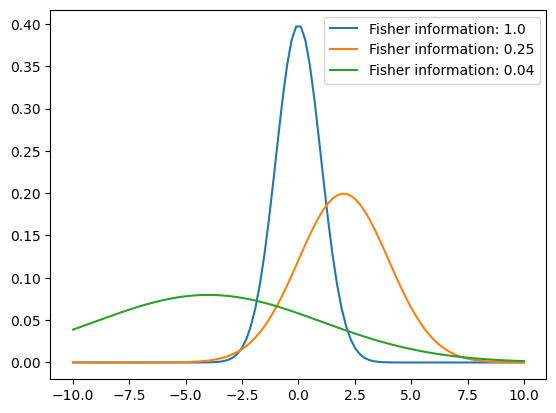

In [6]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

gen = np.random.default_rng()

x = np.linspace(-10,10,100)
mu1,sigma1 = 0,1
mu2,sigma2 = 2,2
mu3,sigma3 = -4,5

ax = plt.gca()
ax.plot(x,stats.norm.pdf(x,mu1,sigma1),label=f"Fisher information: {1/sigma1**2}")
ax.plot(x,stats.norm.pdf(x,mu2,sigma2),label=f"Fisher information: {1/sigma2**2}")
ax.plot(x,stats.norm.pdf(x,mu3,sigma3),label=f"Fisher information: {1/sigma3**2}")
plt.legend()
plt.show()
plt.close()


In [24]:
def sample_gaussian_mixture(n_samples,weights,mus,covars,generator):

    samples = np.zeros((n_samples,mus.shape[-1]))
    
    for ii in range(n_samples):

        gauss = generator.choice(len(weights),1,p=weights).squeeze()
        
        mean = mus[gauss,]
        cov = covars[gauss]
        samples[ii] = generator.multivariate_normal(mean=mus[gauss],cov=covars[gauss])
        
    return samples

In [34]:
from sklearn.mixture import GaussianMixture

mu1,cov1 = np.array([0,0]),np.array([[2,1],[1,2]])
mu2,cov2 = np.array([2,2]),np.array([[3,-1],[-1,3]])
mu3,cov3 = np.array([-4,-4]),np.array([[3,1],[1,1]])

weights1 = np.array([0.33,0.33,0.33])
weights1 /= np.sum(weights1)
weights2 = np.array([0.1,0.1,0.8])

samples_gm1 = sample_gaussian_mixture(1000,weights1,np.vstack([mu1,mu2,mu3]),np.stack([cov1,cov2,cov3]),gen)
samples_gm2 = sample_gaussian_mixture(1000,weights1,np.vstack([mu1,mu2,mu3]),np.stack([cov1,cov2,cov3]),gen)

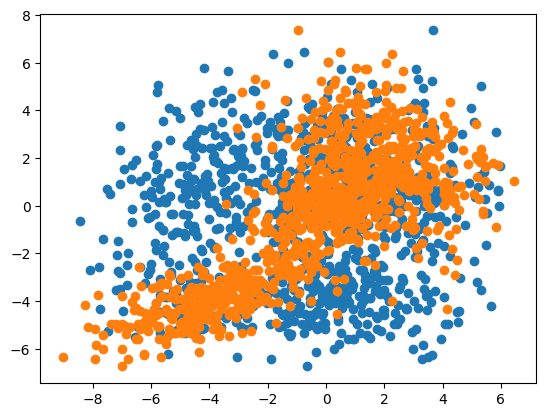

In [35]:
ax = plt.gca()

ax.scatter(samples_gm1[:,0],samples_gm2[:,1])
ax.scatter(samples_gm2[:,0],samples_gm2[:,1])
plt.show()
plt.close()

In [46]:
from bubblewrap import Bubblewrap
from tqdm import tqdm

def bubblewrap_data(data,n_nodes,n_passes=5):
    
    N = n_nodes             # number of nodes to tile with
    lam = 1e-3          # lambda 
    nu = 1e-3           # nu
    eps = 1e-3          # epsilon sets data forgetting
    step = 8e-5         # for adam gradients
    
    B_thresh = -10      # threshold for when to teleport (log scale)    
    batch = True       # run in batch mode 
    
    go_fast = True     # flag to skip computing priors, predictions, and entropy for optimal speed
    future_distance = 1

    T = data.shape[0]      
    d = data.shape[1]       

    M = T//100              # small set of data seen for initialization
    batch_size = T//100      # batch mode size; if not batch is 1
    
    bw = Bubblewrap(N, d, step=step, lam=lam, M=M, eps=eps, nu=nu, B_thresh=B_thresh, batch=batch, batch_size=batch_size, go_fast=go_fast, future_distance=future_distance)

    print('initializing bubblewrap...')
    step = batch_size
    for i in np.arange(0, M, step): 
        bw.observe(data[i:i+step])
    bw.init_nodes()
    
    init = -M
    end = T-M
    step = batch_size

    #print('fitting bubblewrap....')
    for p in tqdm(range(n_passes),desc='fitting bubblewrap...'):
        order = np.random.choice(len(data),len(data),replace=False)
        ordered_data = data[order,:]
        for i in np.arange(init, end, step):#,desc='fitting bubblewrap....'):
            future_index = i+M+step - 2 + bw.future_distance
            future_x = ordered_data[future_index] if future_index < ((end- 1) + M ) else None
        
            bw.observe(ordered_data[i+M:i+M+step], future_x=future_x)
            bw.e_step()  
            bw.grad_Q()
            nNan = np.sum(np.isnan(bw.L))
            if nNan > 0:
                print(f"after iter {i+1}, {nNan} nans in L")

    return bw

In [49]:
def confidence_ellipse(mu,cov, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [47]:
bw1 = bubblewrap_data(samples_gm1,n_nodes=3,n_passes=15)
bw2 = bubblewrap_data(samples_gm2,n_nodes=3,n_passes=15)


initializing bubblewrap...


fitting bubblewrap...: 100%|█████████████████████████████████████| 15/15 [00:01<00:00, 11.26it/s]


initializing bubblewrap...


fitting bubblewrap...: 100%|█████████████████████████████████████| 15/15 [00:01<00:00, 11.53it/s]


In [48]:
print(bw1.alpha)
print(bw2.alpha)

[0.33333334 0.33333334 0.33333334]
[1.8658605e-08 7.3727864e-01 2.6272133e-01]


In [ ]:
ax = plt.gca()
ax.scatter(samples_gm1[:,0],samples_gm2[:,1])
ax.scatter(samples_gm2[:,0],samples_gm2[:,1])
for ii in range(3):
    confidence_ellipse(bw1.mu,bw1._get_precision() # should be inverse